In [2]:
#%matplotlib notebook
import h5py
from h5py import *
#from netCDF4 import *
import numpy as np
import sys
import os
import matplotlib.pyplot as plt
import scipy.signal
import copy

import itertools
from itertools import islice

In [4]:
dat = h5py.File("daymet_raw_71p2824_-156p6194.h5",'r')
#dat_daily = h5py.File("daymet_raw_71p2824_-156p6194_corrected.h5",'w')
path='/Users/ajc/Core/PreProcessing/forcing_data/Barrow_Alaska/barrow1985-2015-detrend-smooth-30pc.h5'

Daymet_FM = h5py.File(path,'r')

In [13]:
#print(dat.keys())

dat_daily = dict()#copy.deepcopy(dat)
dat_annual = dict()
for k,d in dat.items():
    dat_daily[k] = np.array(dat[k])#copy.deepcopy(dat[k])
    #dat_annual[k] = np.reshape(dat[k],(-1, 365)).mean(axis=1)
    
#Truncate Relative Humidity data, [0.7,1.0]
"""
for i in range(len(dat_daily['relative humidity [-]'][:])):
    #break
    d = 1.3*dat_daily['relative humidity [-]'][i]
    if (d <0.7):
        dat_daily['relative humidity [-]'][i] = 0.8
    elif (d > 1):
        dat_daily['relative humidity [-]'][i] = 1
"""
print (dat_daily.keys())
for k,d in dat_daily.items():
    dat_annual[k] = np.reshape(dat_daily[k],(-1, 365)).mean(axis=1)
#print(dat_annual['P']*1000*86400*365.) #annaual precip in mm/yr
#print(dat_daily.keys())

dict_keys(['air temperature [K]', 'incoming shortwave radiation [W m^-2]', 'precipitation rain [m s^-1]', 'precipitation snow [m SWE s^-1]', 'relative humidity [-]', 'time [s]', 'wind speed [m s^-1]'])


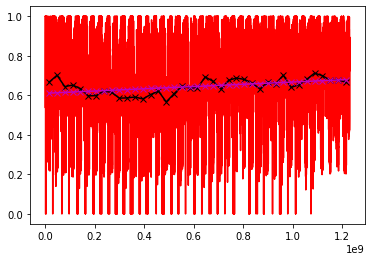

In [6]:
poly_ = np.polyfit(dat_annual['time [s]'], dat_annual['relative humidity [-]'], 1)
poly = np.poly1d(poly_)
plt.plot(dat_daily['time [s]'], dat_daily['relative humidity [-]'], 'r',label='Daily ave.')
plt.plot(dat_annual['time [s]'], dat_annual['relative humidity [-]'], 'k-x',label='Annual ave.')
plt.plot(dat_annual['time [s]'], poly(dat_annual['time [s]']), 'm-x',label='linear fit')

#plt.xlabel('Time [Yr]')
#plt.ylabel('Air Temperature [K]')
#plt.ylabel('Total Precipitation [mm]')
#plt.xlim([0,31.5])
#plt.legend(loc='lower right')
#plt.title('Trend in the annual average air temperatures')
#plt.savefig('temp-annual-avg.png',bbox_inches="tight",dpi=250,figsize=(12,12))
#plt.show()
#plt.close()

#print (dat_annual['T'])

air temperature [K]


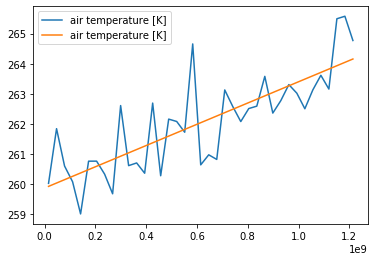

incoming shortwave radiation [W m^-2]


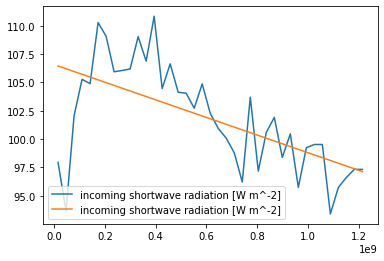

precipitation rain [m s^-1]


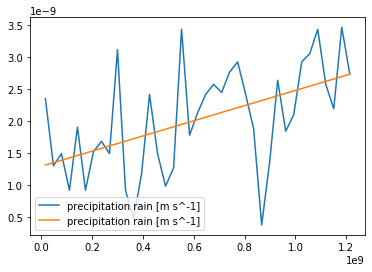

precipitation snow [m SWE s^-1]


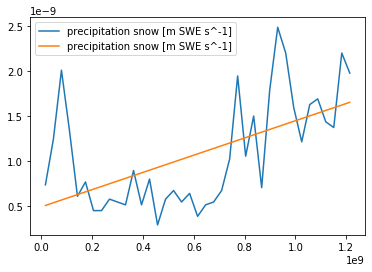

relative humidity [-]


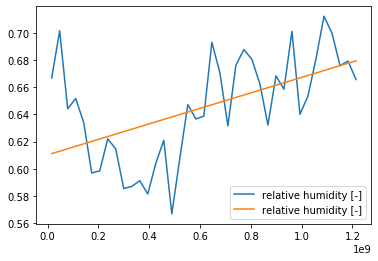

wind speed [m s^-1]


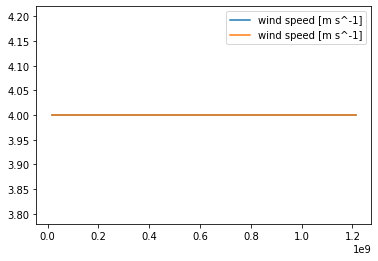

array([138.64186047, 235.08837209, 379.75813953, 253.17209302,
       114.53023256, 144.66976744,  84.39069767,  84.39069767,
       108.50232558, 102.4744186 ,  96.44651163, 168.78139535,
        96.44651163, 150.69767442,  54.25116279, 108.50232558,
       126.58604651, 102.4744186 , 120.55813953,  72.33488372,
        96.44651163, 102.4744186 , 126.58604651, 192.89302326,
       367.70232558, 198.92093023, 283.31162791, 132.61395349,
       337.5627907 , 470.17674419, 415.9255814 , 301.39534884,
       229.06046512, 307.42325581, 319.47906977, 271.25581395,
       259.2       , 415.9255814 , 373.73023256])

In [7]:

dat_daily_dtrend = dict()

for k,d in dat_daily.items():
    if not k.startswith('time'):
        print (k)
        poly_ = np.polyfit(dat_annual['time [s]'], dat_annual[k], 1)
        poly = np.poly1d(poly_)
        dat_daily_dtrend[k] = d - poly(dat_daily['time [s]']) + d.mean()
        #plt.plot(dat_daily['time [s]'], dat_daily_dtrend[k], label = k,color='c')
        #plt.plot(dat_daily['time [s]'], dat_daily[k], 'r', label = k)
        plt.plot(dat_annual['time [s]'], dat_annual[k], label = k)
        plt.plot(dat_annual['time [s]'], poly(dat_annual['time [s]']), label = k)
        plt.legend()
        plt.show()
np.reshape(dat_daily['precipitation snow [m SWE s^-1]'],(-1,365)).mean(axis=1)*1000*86400*365*6

In [8]:
path= '/Users/ajc/FUSE/simulations/forcing_data/Barrow-Validation/Barrow-2010_2016-updated-30pc.h5'
Observed_barrow = h5py.File(path,'r')

In [15]:
#Detrend temperature data
# Snow precip times 5, no other changes (means trend is preserved)
# Rain precip times 1.3, no other changes (means trend is preserved)
# Relative humidity truncated 0.7, 0.99
# wind speed from observed Barrow data
Daymet_finaldata = dict()
#alpha_rain, alpha_snow = 5, 1.3
alpha_rain, alpha_snow = 1, 1
for key, d in dat_daily.items():
    if 'wind' in key:
        print (key)
        l = len(Observed_barrow['precipitation snow [m SWE s^-1]'])%365
        dwind = np.concatenate([Observed_barrow[key][:-l],]*7)
        print (len(dwind), len(Observed_barrow[key][:-l]))
        l2 = len(dat_daily[key])
        Daymet_finaldata[key] = dwind[:l2]
    elif not 'precipitation' in key:
        Daymet_finaldata[key] = dat_daily[key]
        
Daymet_finaldata['air temperature detrended [K]'] = dat_daily_dtrend['air temperature [K]']
for key, d in dat_daily.items():
    if 'precipitation snow [m SWE s^-1]' in key:
        
        Precip_total = [alpha_rain*x + alpha_snow*y for x,y in zip(d,dat_daily['precipitation rain [m s^-1]'][:])]
        precip_rain = np.zeros(len(dat_daily['time [s]']))
        precip_snow = np.zeros(len(dat_daily['time [s]']))
        for i,t in enumerate(dat_daily['air temperature [K]']):
            if t < 273.15:
                precip_snow[i] = Precip_total[i]
            else:
                precip_rain[i] = Precip_total[i]
        Daymet_finaldata[key] = np.array(precip_snow)
        Daymet_finaldata['precipitation rain [m s^-1]'] = np.array(precip_rain)
    else:
        continue
        
# Looping over Fengming data for for relative humidity

def year_generator(dat):
    #print ('Shape: ',dat.shape[0])
    positions3 = islice(itertools.cycle(years),26,None)
    
    n = int(next(positions3))
    for i in itertools.cycle(range(dat.shape[0])):
        if (n + i) <= 30:
            print ('I+ ',i,n, n+i,np.mean(dat[n+i,:]),dat.shape[0])
            yield dat[n+i,:]
        else:
            #print ('I ',i-6,np.mean(dat[i-6,:]))
            yield dat[i-5,:]
            
years = np.linspace(0,38,39)

normalized = np.reshape(Daymet_FM['relative humidity [-]'],(-1,365))
d = np.array([x for yr, x in zip(years, year_generator(normalized))])
Daymet_finaldata['relative humidity [-]'] = d

normalized = np.reshape(Daymet_FM['incoming longwave radiation [W m^-2]'],(-1,365))
d = np.array([x for yr, x in zip(years, year_generator(normalized))])
Daymet_finaldata['incoming longwave radiation [W m^-2]'] = d


if alpha_rain ==1 and alpha_snow ==1:
    outfile = h5py.File('barrow1980-2018_corrected.h5','w')
else:
    outfile = h5py.File('barrow1980-2018_adjusted.h5','w')
for key,d in Daymet_finaldata.items():
    outfile.create_dataset(key, data=d.ravel())
outfile.close()



wind speed [m s^-1]
15330 2190
I+  0 26 26 0.8140997395547943 31
I+  1 26 27 0.8248874740296804 31
I+  2 26 28 0.807504284760274 31
I+  3 26 29 0.8628648687214613 31
I+  4 26 30 0.8904746004566212 31
I+  0 26 26 0.8140997395547943 31
I+  1 26 27 0.8248874740296804 31
I+  2 26 28 0.807504284760274 31
I+  3 26 29 0.8628648687214613 31
I+  4 26 30 0.8904746004566212 31
I+  0 26 26 243.5616234589041 31
I+  1 26 27 241.30464480593605 31
I+  2 26 28 244.25311506849314 31
I+  3 26 29 254.39690393835616 31
I+  4 26 30 252.90187687785388 31
I+  0 26 26 243.5616234589041 31
I+  1 26 27 241.30464480593605 31
I+  2 26 28 244.25311506849314 31
I+  3 26 29 254.39690393835616 31
I+  4 26 30 252.90187687785388 31


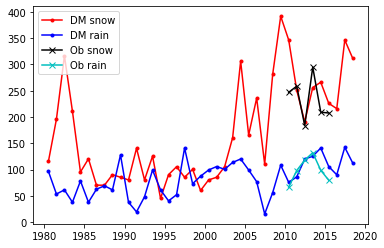

In [10]:
#Plot and compare Daymet data and Barrow observed
for key, d in Daymet_finaldata.items():
    if 'precipitation snow [m SWE s^-1]' in key:
        dsnow1 = np.reshape(d,(-1,365)).mean(axis=1)
        dsnow = [1.*x*1000*86400*365. for x in dsnow1]
  
        drain1 = np.reshape(Daymet_finaldata['precipitation rain [m s^-1]'],(-1,365)).mean(axis=1)
        drain = [1.*x*1000*86400*365. for x in drain1]
        
        dsnow_time = [1980 + t/86400/365.  for t in dat_annual['time [s]']]
        plt.plot(dsnow_time, dsnow, 'r.-',label='DM snow')
        plt.plot(dsnow_time, drain, 'b.-',label='DM rain')
        
        
        l = len(Observed_barrow['precipitation snow [m SWE s^-1]'])%365
        dsnow_ob1 = np.reshape(Observed_barrow['precipitation snow [m SWE s^-1]'][:-l],(-1,365)).mean(axis=1)
        dsnow_ob = [x*1000*86400*365. for x in dsnow_ob1]
        drain_ob1 = np.reshape(Observed_barrow['precipitation rain [m s^-1]'][:-l],(-1,365)).mean(axis=1)
        drain_ob = [x*1000*86400*365. for x in drain_ob1]
        d2_time1 = np.reshape(Observed_barrow['time [s]'][:-l],(-1,365)).mean(axis=1)
        d2_time = [2010 + t/86400/365. for t in d2_time1] 
        
        plt.plot(d2_time, dsnow_ob, 'k-x',label='Ob snow')
        plt.plot(d2_time, drain_ob, 'c-x',label='Ob rain')
        plt.legend()
        #print (np.mean(d1[30:36]),len(d1))
        #print (np.mean(d2))


In [ ]:
for key, d in Daymet_finaldata.items():
    if 'air temperature [K]' in key:  
        dtemp = np.reshape(Daymet_finaldata[key],(-1,365)).mean(axis=1)
        #dtemp1 = np.reshape(Daymet_finaldata['air temperature detrended [K]'],(-1,365)).mean(axis=1)
        d1_time1 = np.reshape(Daymet_finaldata['time [s]'],(-1,365)).mean(axis=1)
        d1_time = [1980 + t/86400/365. for t in d1_time1] 
        plt.plot(d1_time, dtemp, 'r.-',label='Daily ave.')
        #plt.plot(d1_time, dtemp1, 'g.-',label='Daily ave.')
        
        l = len(Observed_barrow['precipitation snow [m SWE s^-1]'])%365
        d2temp = np.reshape(Observed_barrow[key][:-l],(-1,365)).mean(axis=1)
        
        d2_time1 = np.reshape(Observed_barrow['time [s]'][:-l],(-1,365)).mean(axis=1)
        
        d2_time = [2010 + t/86400/365. for t in d2_time1] 
        plt.plot(d2_time, d2temp, 'k-x',label='Annual ave.')
        plt.ylabel('air temperature')
        #print (np.mean(d11[30:36]),len(d11))
        #print (np.mean(d21))
print (Daymet_finaldata.keys())

In [ ]:
d_rh = np.reshape(Daymet_finaldata['relative humidity [-]'],(-1,365)).mean(axis=1)
d1_time1 = np.reshape(Daymet_finaldata['time [s]'],(-1,365)).mean(axis=1)
d1_time = [1980 + t/86400/365. for t in d1_time1] 

l = len(Observed_barrow['relative humidity [-]'])%365
d_rh_ob = np.reshape(Observed_barrow['relative humidity [-]'][:-l],(-1,365)).mean(axis=1)
d2_time1 = np.reshape(Observed_barrow['time [s]'][:-l],(-1,365)).mean(axis=1)
d2_time = [2010 + t/86400/365. for t in d2_time1] 

#plt.plot(d1_time, d_rh, 'r.-',label='DM- RH')
#plt.plot(d2_time, d_rh_ob, 'k.-',label='Ob- RH')
print (np.min(Observed_barrow['relative humidity [-]']), np.max(Observed_barrow['relative humidity [-]']))
print (np.min(Daymet_finaldata['relative humidity [-]']), np.max(Daymet_finaldata['relative humidity [-]']))

In [ ]:
d_rh = np.reshape(Daymet_finaldata['relative humidity [-]'],(-1,365))
d1_time1 = np.reshape(Daymet_finaldata['time [s]'],(-1,365))
d1_time = [1980 + t/86400/365. for t in d1_time1] 

d_rh_fm = np.reshape(Daymet_FM['relative humidity [-]'],(-1,365))
d1_time1_fm = np.reshape(Daymet_FM['time [s]'],(-1,365))
d1_time_fm = [1985 + t/86400/365. for t in d1_time1_fm] 

l = len(Observed_barrow['relative humidity [-]'])%365
d_rh_ob = np.reshape(Observed_barrow['relative humidity [-]'][:-l],(-1,365))
d2_time1 = np.reshape(Observed_barrow['time [s]'][:-l],(-1,365))
d2_time = [2010 + t/86400/365. for t in d2_time1] 

plt.plot(d1_time[30], d_rh[30], 'r*-',label='DM- RH')
plt.plot(d1_time[30], d_rh[0], 'm-',label='DM- RH')
plt.plot(d2_time[0], d_rh_ob[0], 'k.-',label='Ob- RH')
#plt.plot(d1_time_fm[25], d_rh_fm[25], 'g.-',label='DM- RH_feng')
plt.legend()
print (np.min(Observed_barrow['relative humidity [-]']), np.max(Observed_barrow['relative humidity [-]']))
print (np.min(Daymet_finaldata['relative humidity [-]']), np.max(Daymet_finaldata['relative humidity [-]']))